In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Ising Model
Reference: *Modelling Brain Function* by Daniel Amit, Chapter 3

In [50]:
class SpinSystem:
    ''' 
    Store a spin system with interaction matrix J, spin state S, and temperature T
    Has methods to update spin-by-spin according to Glauber dynamics

    ...
    
    Attributes
    --------------
    J : np.array(N,N)
        interaction matrix
    S : np.array(N)
        spin array
    T : float
        system temperature
    anneal : boolean
        whether or not to simulate annealing
    anneal_args : float
        argument(s) for decreasing the temperature
    
    Sub-functions
    --------------
    energy()
        returns current value of total energy in the absence of an external field (eqn 3.59)
    decrease_temperature(a = schedule parameter)
        defines the annealing schedule
    update(k = spin index)
        determines whether or not spin k flips and updates the spin array accordingly
        decrease temperature with each step, if annealling is on
    '''
    
    def __init__(self, J, S, T, anneal, anneal_args=0.005):
        self.J = J
        self.S = S
        self.T = T
        self.anneal = anneal
        self.anneal_args = anneal_args
    
    def energy(self):
        return -0.5*(self.S.dot(self.J.dot(self.S)))
    
    def decrease_temperature(self):
        self.T = self.T/(1 + self.anneal_args*self.T)
    
    def update(self, k):
        delta_E = 2.*self.S[k]*(self.J[k].dot(self.S)) # Change in energy due to flipping spin k (eqn 3.60)
        if self.T > 0:
            flip_prob = np.exp(-delta_E/self.T)
        else:
            flip_prob = 0
        random = np.random.rand()

        if (delta_E < 0) or (random < flip_prob):
            self.S[k] = -self.S[k]
            
        if self.anneal:
            self.decrease_temperature()

### Noisy asynchronous dynamics with detailed balance

Initial spin configuration:
[-1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1
 -1 -1  1  1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1  1  1  1 -1  1  1  1 -1  1  1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1 -1  1
  1 -1 -1 -1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1  1 -1  1 -1
 -1 -1 -1  1]
Final spin configuration:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


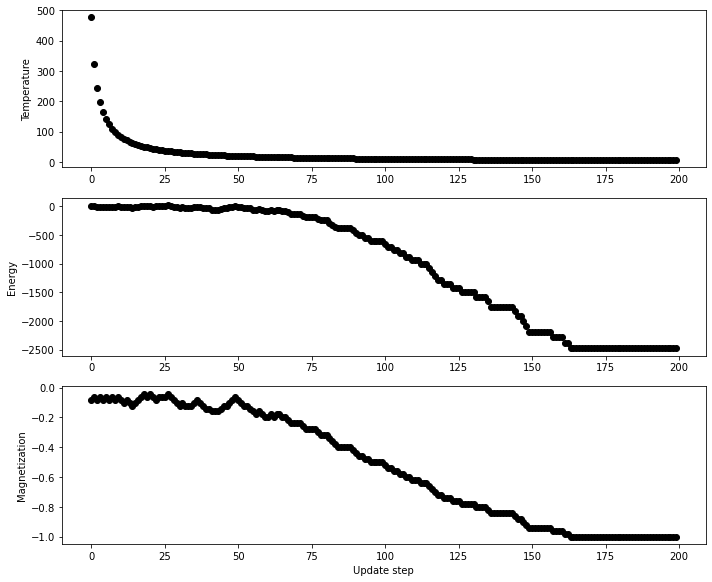

In [76]:
# Choose a system size
N = 100

# Random positive interactions with detailed balance
J_rand = np.random.uniform(0,1,size=(N,N)) # a ferromagnetic system
J_rand = (J_rand + J_rand.T)/2             # make it symmetric, to satisfy detailed balance
np.fill_diagonal(J_rand, 0)                # make sure the spins don't self-interact

S_rand = np.random.choice([-1,1],size=N)
T_rand = np.random.uniform(0, 500)

system_rand = SpinSystem(J_rand, S_rand, T_rand, True, 0.001)

total_time = 2*N # how many time steps to take
time = range(total_time)
energies = np.zeros(total_time)
magnetizations = np.zeros(total_time)
temperatures = np.zeros(total_time)
    
print("Initial spin configuration:")
print(system_rand.S)

for t in time:
    energies[t] = system_rand.energy()
    temperatures[t] = system_rand.T
    magnetizations[t] = np.average(system_rand.S)
    
    system_rand.update(t%N) # update spin t mod N

print("Final spin configuration:")
print(system_rand.S)

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.ylabel('Temperature')
plt.plot(time, temperatures, 'ko')

plt.subplot(3, 1, 2)
plt.ylabel('Energy')
plt.plot(time, energies, 'ko')

plt.subplot(3, 1, 3)
plt.ylabel('Magnetization')
plt.plot(time, magnetizations, 'ko')

plt.tight_layout()
plt.xlabel('Update step')
plt.show()

# Hopfield Model
Reference: *Neural networks and physical systems with emergent collective computational abilities* by J. J. Hopfield

In [107]:
def hamming_dist(S1, S2):
    ''' Calculate the bit-by-bit distance between two spin systems S1 and S2 '''
    N = len(S1)
    distance = 0
    for i in range(N):
        if S1[i] != S2[i]:
            distance += 1
    return distance

def generate_hopf(states):
    ''' Generate interaction matrix to store given states '''

    N = states.shape[1]
    J_hopf = np.empty((N,N))

    for i in range(N):
        for j in range(N):
            total = 0
            for s in range(n):
                total += states[s][i]*states[s][j]

            J_hopf[i][j] = total

    np.fill_diagonal(J_hopf, 0) # make sure the spins don't self-interact
    
    return J_hopf

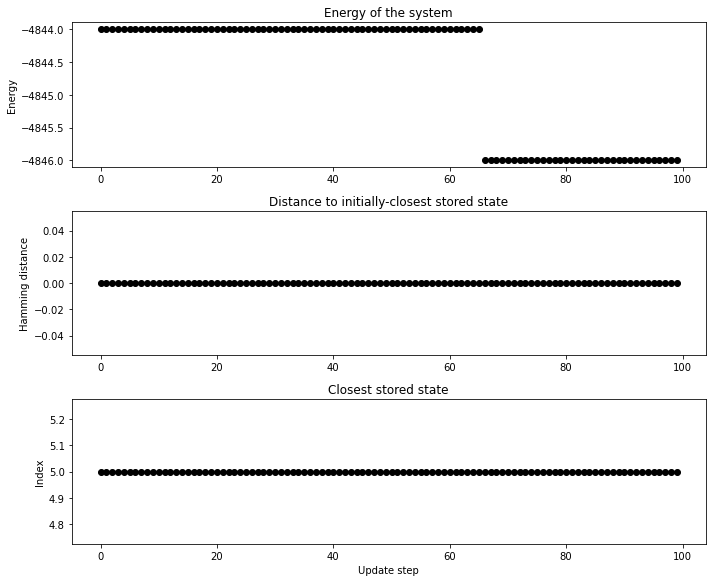

In [108]:
# Choose a system size
N = 100

# Choose n random states of size N to store
n = 15

# Generate random states to store
stored_states = np.empty((n, N))
for i in range(n):
    stored_states[i] = np.random.choice([-1,1],size=N)

# Choose a stored state as the initial state
S0 = stored_states[5]

T_hopf = 0

J_hopf = generate_hopf(stored_states)

system_hopf = SpinSystem(J_hopf, S0, T_hopf, False)

# Find the stored state closest to S0 
# (for an initial state that is stored, this is obvious, but leave it in for random initial states)
distances = [hamming_dist(S0, state) for state in stored_states]
closest = np.argmin(distances) # index of the closest stored state

total_time = N # how many time steps to take
time = range(total_time)
energies = np.zeros(total_time)
temperatures = np.zeros(total_time)
closest_dist = np.zeros(total_time)
closest_state = np.zeros(total_time)

for t in time:
    energies[t] = system_hopf.energy()
    temperatures[t] = system_hopf.T
    closest_dist[t] = hamming_dist(system_hopf.S, stored_states[closest])
    
    distances = [hamming_dist(system_hopf.S, state) for state in stored_states]
    closest_state[t] = np.argmin(distances)
    
    system_hopf.update(t%N) # update spin t mod N

plt.figure(figsize=(10, 8))

# plt.subplot(3, 1, 1)
# plt.ylabel('Temperature')
# plt.plot(time, temperatures, 'ko')

plt.subplot(3, 1, 1)
plt.title('Energy of the system')
plt.ylabel('Energy')
plt.plot(time, energies, 'ko')

plt.subplot(3, 1, 2)
plt.title('Distance to initially-closest stored state')
plt.ylabel('Hamming distance')
plt.plot(time, closest_dist, 'ko')

plt.subplot(3, 1, 3)
plt.title('Closest stored state')
plt.ylabel('Index')
plt.plot(time, closest_state, 'ko')

plt.tight_layout()
plt.xlabel('Update step')
plt.show()

In [113]:
def find_error(system):
    ''' For a given system, evolve and measure final Hamming distance from initial state '''

    initial_state = system.S
    
    total_time = N # how many time steps to take
    time = range(total_time)
    for t in time:
        system_hopf.update(t%N) # update spin t mod N
        
    return hamming_dist(initial_state, system.S)   

In [114]:
N = 100
n = 15

stored_states = np.empty((n, N))
for i in range(n):
    stored_states[i] = np.random.choice([-1,1],size=N)

J_hopf = generate_hopf(stored_states)

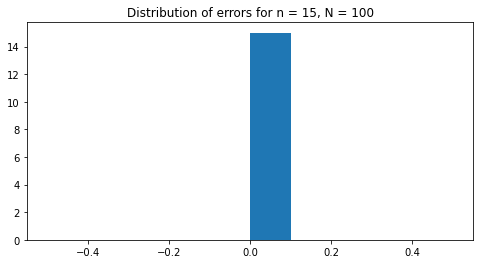

In [120]:
errors = np.empty(n)
T_hopf = 0

# Iterate through all n stored states and see if they eventually have errors
for i in range(n):
    system_hopf = SpinSystem(J_hopf, stored_states[i], T_hopf, False)
    errors[i] = find_error(system_hopf)
        
plt.figure(figsize=(8, 4))
plt.hist(errors)
plt.title("Distribution of errors for n = {}, N = {}".format(n, N))
plt.ylabel("Count")
plt.xlabel("Number of errors")
plt.show()